<a href="https://colab.research.google.com/github/techwizi/SURGE-23-Cryptocurrency-Price-Forecasting/blob/main/LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**LSTM Model**


Importing the necessary libraries

In [ ]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

Storing datasets of Bitcoin and Ethereum in dataframe

In [ ]:
df = pd.read_csv('BTC-USD.csv')
# df = pd.read_csv('coin_Ethereum.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-06-19,6742.390137,6822.500000,6709.919922,6769.939941,6769.939941,4057029888
1,2018-06-20,6770.759766,6821.560059,6611.879883,6776.549805,6776.549805,3888640000
2,2018-06-21,6780.089844,6810.939941,6715.169922,6729.740234,6729.740234,3529129984
3,2018-06-22,6737.879883,6747.080078,6006.600098,6083.689941,6083.689941,5079810048
4,2018-06-23,6090.100098,6224.819824,6071.810059,6162.479980,6162.479980,3431360000


In [ ]:
# Checking the shape of our original dataframe
df.shape

(1827, 7)

Now let's plot the close price data

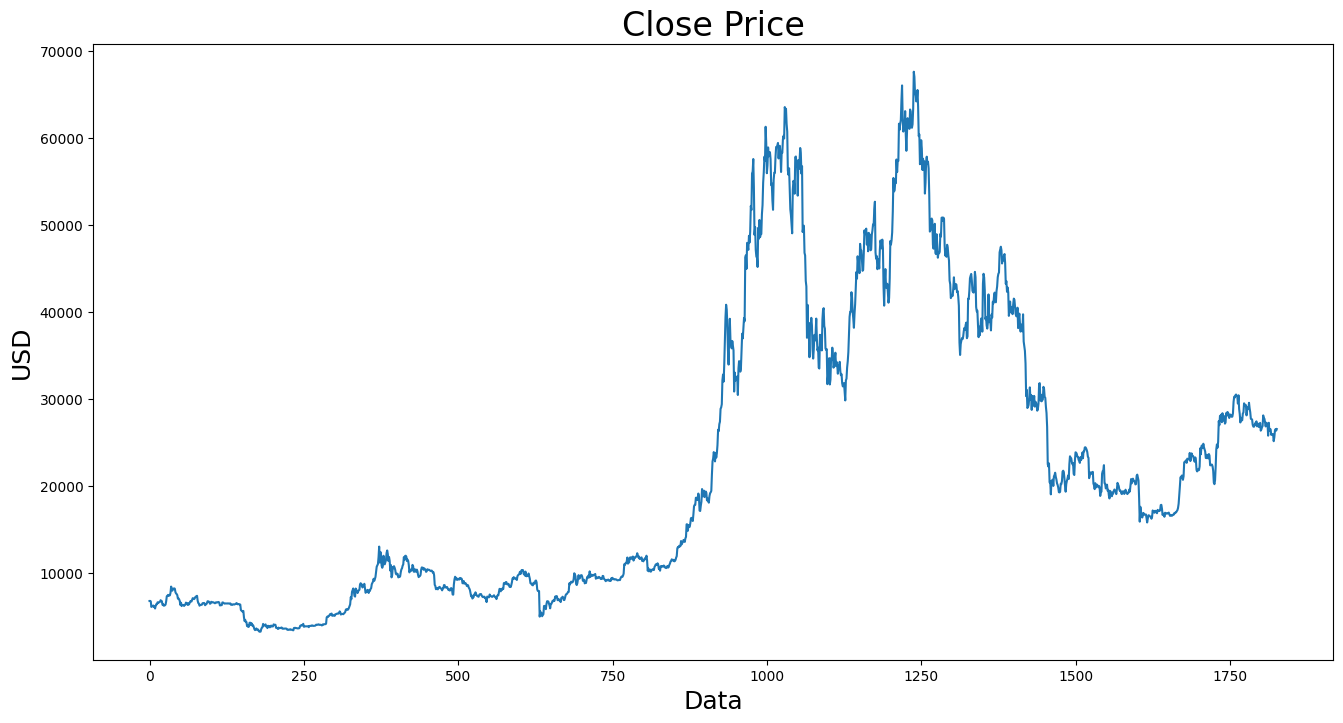

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Close Price', fontsize=24)
plt.plot(df['Close'])
plt.xlabel('Data', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.show()

Since we only require the adjusted close price of a particular cryptocurrency for our analysis, I will filter other details

In [ ]:
#Creat a new dataframe with only Close Price
data = df.filter(['Close'])
#Convert the dataframe to numpy array
dataset = data.values
# Get the number of rows to train the model on. we need this number to create our train and test sets
# math.ceil will round up the number
training_data_len = math.ceil(len(dataset) * .8) # We are using %80 of the data for training
training_data_len

1462

Now that we have our close price values in a seprated dataframe we can normalize our data within (0,1) range using MinMax scalar to improve efficiency of DL model

In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.05492266],
       [0.05502541],
       [0.05429776],
       ...,
       [0.36178906],
       [0.35907706],
       [0.36191785]])

This model will predict the price by looking the last 60 days of price. This will help our model to predict a better price and not just a random number that would have less than %50 accuracy.

In [ ]:
# Creat the training dataset
train_data = scaled_data[0:training_data_len, :]
# Split the data into X_train and y_train data sets
X_train = []
y_train = []

for i in range(60, len(train_data)):
  X_train.append(train_data[i-60: i, 0])
  y_train.append(train_data[i, 0])


  if i <= 60:
    print(X_train)
    print(y_train)
    print()

[array([0.05492266, 0.05502541, 0.05429776, 0.04425502, 0.0454798 ,
       0.0456469 , 0.04682754, 0.04441015, 0.04539663, 0.04145306,
       0.04634751, 0.04923418, 0.04895158, 0.0525014 , 0.05118646,
       0.05224288, 0.0528894 , 0.05342352, 0.05627491, 0.0549839 ,
       0.05448445, 0.04808309, 0.04908977, 0.04651089, 0.04665452,
       0.04724631, 0.04854462, 0.05448445, 0.06348942, 0.06426261,
       0.06575616, 0.06400379, 0.0650167 , 0.06500426, 0.06955299,
       0.08063893, 0.07686341, 0.07329105, 0.07660878, 0.07703068,
       0.07743966, 0.07684926, 0.07063071, 0.06821303, 0.06731515,
       0.06525142, 0.05900955, 0.05956341, 0.05774964, 0.0546612 ,
       0.04770768, 0.05178711, 0.04582536, 0.04755114, 0.04797023,
       0.04757974, 0.04605853, 0.04774996, 0.04815739, 0.05197986])]
[0.04954134551775858]



In [ ]:
len(X_train)

1402

LSTM model needs the data to be an *array*. So here we will convert X_train and y_train to an array list.

In [ ]:
# Convert the X_train and y_train to numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train.shape

(1402, 60)

Since LSTM needs the data to be inputet by 3 dimension. So we will reshape the X_train array

In [ ]:
# Reshape the data because LSTM needs 3 dim
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # we make it like pros. it wanna say "np.reshape(X_train, (2083, 60, 1))"
X_train.shape

(1402, 60, 1)

Now that we finish creating our train data, we can create our *test data*

In [ ]:
# Create the testing dataset
# Create a new array containing scaled values from index 2083
test_data = scaled_data[training_data_len - 60 : , :]

#Create the data sets X_test and y_test
X_test = []
y_test = dataset[training_data_len : , :]
for i in range(60, len(test_data)):
  X_test.append(test_data[i-60 : i, 0])


In [ ]:
# Convert the data to a numpy array
X_test = np.array(X_test)

In [ ]:
# Reshape the test data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

**Creating the model**

We are using 2 layers of LSTM and 2 layers of Dense. Our first LSTM layer has `return_sequence=True` because our first and second layers are LSTM and we have to pass the output of the first layer to the second layer.

Our last layer only has one unit in it while we need only one number (one price) to predict.

In [ ]:
# Build LSTM model
tf.random.set_seed(42)

model_1 = Sequential()
model_1.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # we made it like pros ;) , the simple form is "input_shape(60, 1)""
model_1.add(LSTM(50, return_sequences=False))
model_1.add(Dense(25))
model_1.add(Dense(1))

In [ ]:
# Compile the model
model_1.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model_1.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
1402/1402 [==============================] - 15s 8ms/step - loss: 0.0027
Epoch 2/10
1402/1402 [==============================] - 10s 7ms/step - loss: 0.0014
Epoch 3/10
1402/1402 [==============================] - 11s 7ms/step - loss: 0.0010
Epoch 4/10
1402/1402 [==============================] - 11s 8ms/step - loss: 7.4597e-04
Epoch 5/10
1402/1402 [==============================] - 12s 8ms/step - loss: 7.1755e-04
Epoch 6/10
1402/1402 [==============================] - 11s 8ms/step - loss: 6.2519e-04
Epoch 7/10
1402/1402 [==============================] - 11s 8ms/step - loss: 6.0362e-04
Epoch 8/10
1402/1402 [==============================] - 11s 8ms/step - loss: 6.3417e-04
Epoch 9/10
1402/1402 [==============================] - 11s 8ms/step - loss: 5.9036e-04
Epoch 10/10
1402/1402 [==============================] - 11s 8ms/step - loss: 5.9744e-04


In [ ]:
# Get the model_1 predicted price values
predictions_1 = model_1.predict(X_test)
predictions_1 = scaler.inverse_transform(predictions_1)
len(predictions_1)

12/12 [==============================] - 1s 4ms/step


365

In [ ]:
# Get the root mean squared error (RMSE) for model_1
rmse = np.sqrt(np.mean(predictions_1 - y_test)**2)
rmse

127.1941860573629

Text(0.5, 0, 'epochs')

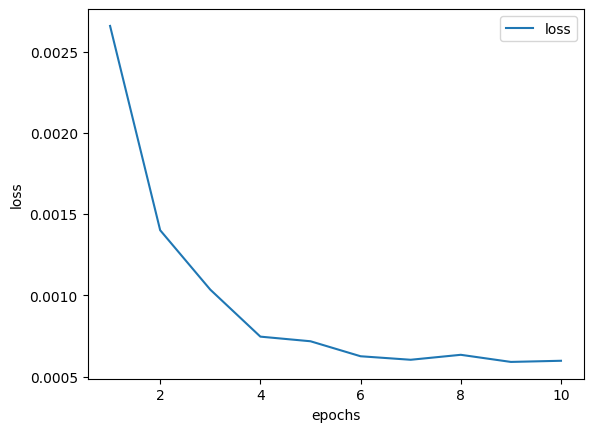

In [ ]:
# Let's plot the history of model_1 and see what's going on
historyForPlot = pd.DataFrame(history.history)
historyForPlot.index += 1 # we plus 1 to the number of indexing so our epochs Plot picture will be counting from 1 not 0.
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")

As we can see, on epochs 6 and 10 we have the less loss and best scores. So we can train our model again with 6 epochs to see which one is better fiting.

In [ ]:
# Train the model again with 7 epochs
# but first we need to create another model so we can compare them together
# building LSTM model_2
tf.random.set_seed(42)

model_2 = Sequential()
model_2.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # we made it like pros ;) | the simple form is "input_shape(60, 1)
model_2.add(LSTM(50, return_sequences=False))
model_2.add(Dense(25))
model_2.add(Dense(1))

# Compile model_2
model_2.compile(optimizer='Adam', loss='mse')

# Fit model_2
history_2 = model_2.fit(X_train, y_train, batch_size=1, epochs=6)

Epoch 1/6
1402/1402 [==============================] - 15s 8ms/step - loss: 0.0027
Epoch 2/6
1402/1402 [==============================] - 11s 8ms/step - loss: 0.0014
Epoch 3/6
1402/1402 [==============================] - 10s 7ms/step - loss: 9.5304e-04
Epoch 4/6
1402/1402 [==============================] - 11s 8ms/step - loss: 7.0404e-04
Epoch 5/6
1402/1402 [==============================] - 11s 8ms/step - loss: 6.9795e-04
Epoch 6/6
1402/1402 [==============================] - 11s 8ms/step - loss: 5.9238e-04


In [ ]:
# Get the model_2 predicted price values
predictions_2 = model_2.predict(X_test)
predictions_2 = scaler.inverse_transform(predictions_2)
len(predictions_2)

12/12 [==============================] - 1s 4ms/step


365

In [ ]:
# Get the root mean squared error (RMSE) for model_2
rmse_2 = np.sqrt(np.mean(predictions_2 - y_test)**2)
rmse_2

1185.150816083048

Now let's see what did our models with predictions and compare our 2 models together:

<ipython-input-98-3dc8d231f6cd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_1['Predictions'] = predictions_1
<ipython-input-98-3dc8d231f6cd>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_2['Predictions'] = predictions_2


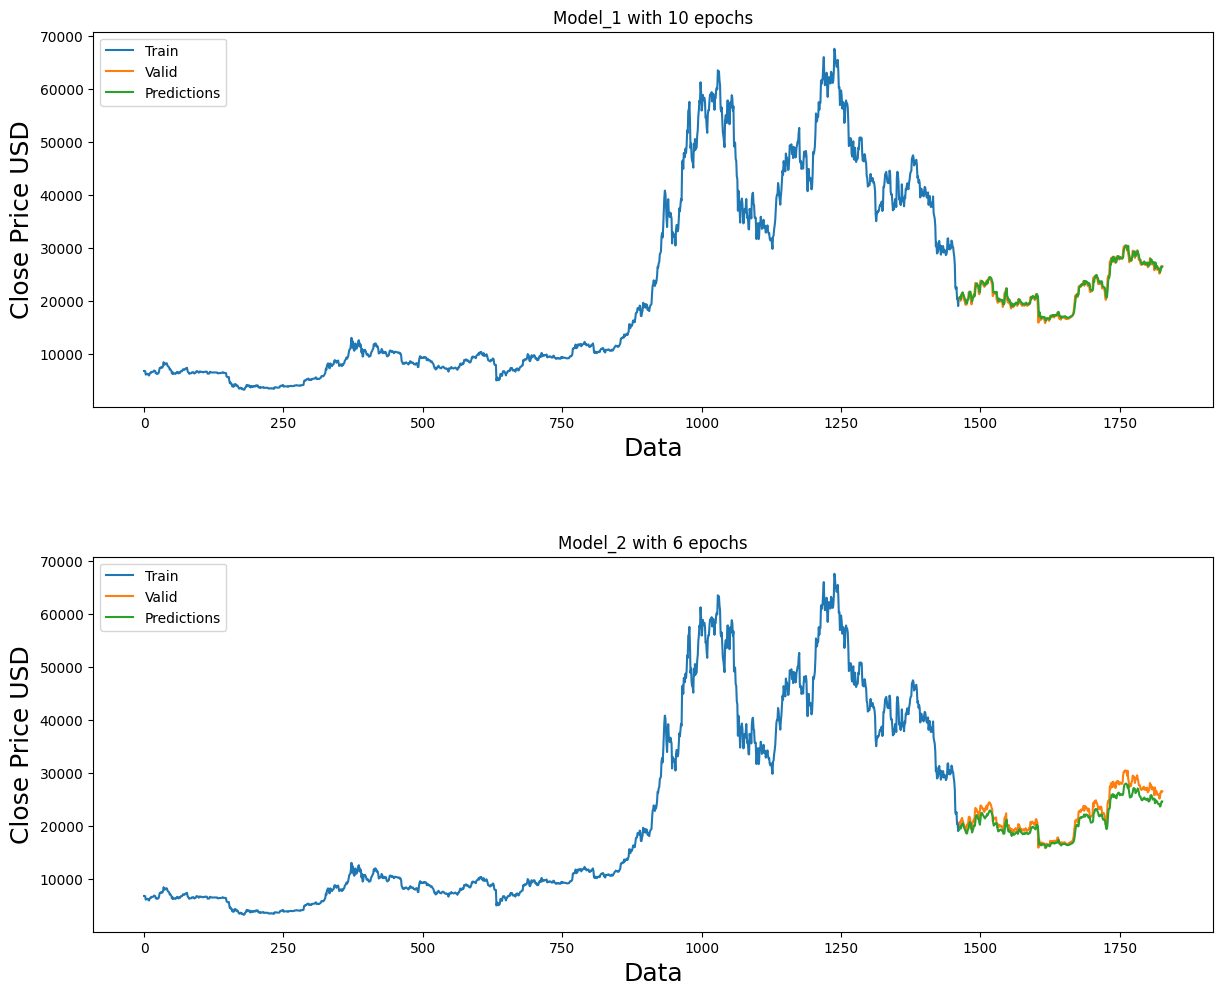

In [ ]:
# Plot the data
train = data[:training_data_len]

#data for model_1
valid_1 = data[training_data_len:]
valid_1['Predictions'] = predictions_1

# data for model_2
valid_2 = data[training_data_len:]
valid_2['Predictions'] = predictions_2

# Visualized the data
#model_1
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title('Model_1 with 10 epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid_1[['Close', 'Predictions']])

plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')

#model_2
plt.subplot(2, 1, 2)
plt.title('Model_2 with 6 epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid_2[['Close', 'Predictions']])

plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

From the plots we can see that our models are making decent predictions on the test data